In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import seaborn as sns
cm = sns.color_palette(as_cmap=True)

## Simulation notes
For the simulation, the time is following this convention:
1 time unit = 10 ms


In [2]:
def epileptor(q, parameters):

	x1,y1,z,x2,y2,g = q
	a1, b1, c1, d1, tau, a2, c2, m, x0, r, s, Irest1, Irest2, Is1, Is2 =\
    parameters['a1'], parameters['b1'], parameters['c1'], parameters['d1'], parameters['tau'], \
    parameters['a2'], parameters['c2'], parameters['m'], parameters['x0'], parameters['r'], \
    parameters['s'], parameters['Irest1'], parameters['Irest2'], parameters['Is1'], parameters['Is2']
    
    ###################  Population 1 #################
	if x1 < 0:
		dx1 = y1  - a1 * (x1)**3  + b1 * (x1)**2 - z + Irest1 + Is1
	else:
		dx1 = y1 + (m -x2 + 0.6 * (z-4)**2)*x1- z + Irest1 + Is1
	dy1 = c1 - d1 * (x1)**2 - y1

	################## Population 2 ################### 
	dx2 = -y2 + x2 - (x2)**3 + Irest2 + 2*g - c2*(z-3.5) + Is2
	if x2 < -0.25:
		dy2 = 1./tau * (-y2)
	else:
		dy2 = 1./tau * (-y2 + a2 * (x2 + 0.25 ))
	dg = -0.01 * (g - 0.1*x1);

	################### Energy #####################"
	dz = r* (s * (x1 - x0) - z)
	#pdb.set_trace()
	return np.hstack((dx1, dy1, dz, dx2, dy2, dg))

# Parameters
parameters = {'a1':1, 'b1':3, 'c1':1, 'd1':5,
              'tau':10, 'a2':6, 'c2':0.3, 'm':0,
              'x0':-2.15, 'r':0.00005, 's':4,
              'Irest1':3.1, 'Irest2':0.45, 'Is1':0, 'Is2':0}

# sim parameters
dt = 0.001
t_sim_init = 100
n_samples_init = int(t_sim_init/dt)
t_sim = 4000
n_samples = int(t_sim/dt)
upsamp = 100
t = np.linspace(0, t_sim, t_sim*upsamp)

# stim parameters
t_start = 100
Is1 = 2
Is2 = 5
I_duration = .3
I_inter = 5 - I_duration
n_stim = 400

lx0 = [-2.2, -2.25, -2.3]
llq, lte = [], []
for x0 in lx0:
    print(x0)
    stim = 1
    parameters['x0'] = x0

    # Find initial conditions by root solving
    q0 = [-1.37, -8.39,  2.92, -0.71,  0.  , -0.14]
    q = fsolve(epileptor, q0, args=parameters)

    for it in range(n_samples_init):
        # Runge-Kutta scheme
        p1 = epileptor(q, parameters)
        p2 = epileptor(q+(dt/2)*p1, parameters)
        p3 = epileptor(q+(dt/2)*p2, parameters)
        p4 = epileptor(q+(dt/2)*p3, parameters)
        q += dt/6 * (p1+2*p2+2*p3+p4)


    lq = []
    for it in range(n_samples):
        # if it%10000==0:
        #     print(it)
        tc = it*dt
        if q[0]>-.5 and stim:
            stim = 0 # no stim after a seizure
            lte.append(tc*upsamp)

        tstim = 0
        if stim:
            for i_stim in range(n_stim):
                if tc>=t_start + i_stim*I_duration + i_stim*I_inter and tc<t_start + (i_stim+1)*I_duration + i_stim*I_inter:
                    tstim = 1
        if tstim:
            parameters['Is2'] = Is2
            parameters['Is1'] = Is1
        else:
            parameters['Is2'] = 0
            parameters['Is1'] = 0

        # Runge-Kutta scheme
        p1 = epileptor(q, parameters)
        p2 = epileptor(q+(dt/2)*p1, parameters)
        p3 = epileptor(q+(dt/2)*p2, parameters)
        p4 = epileptor(q+(dt/2)*p3, parameters)
        q += dt/6 * (p1+2*p2+2*p3+p4)

        if it%int(1/(upsamp*dt))==0:
            lq.append(q.copy())
    llq.append(lq)

llq = np.array(llq)

-2.2


KeyboardInterrupt: 

In [ ]:
ts = -llq[:, :, 0] + llq[:, :, 3]
plt.figure(figsize=(15, 10))
for ix0, x0 in enumerate(lx0[::-1]):
    # time in seconds
    plt.plot(t/100, ts[ix0] + 5*ix0, color=cm[ix0])
plt.xlabel('Time [s]')
# plt.ylabel('Excitability')
# plt.title(str(Is1))
plt.yticks([])
# plt.xlim([0, 4])
# plt.ylim([2, -15])
plt.tight_layout()
plt.savefig('figures/train_stim_diff_exc_time_series_single_exc.svg')

plt.figure(figsize=(15, 7))
for ix0, x0 in enumerate(lx0[::-1]):
    # time in seconds
    plt.plot(t/100, ts[ix0] + 5*ix0, color=cm[ix0])
# plt.xlabel('Time [s]')
# plt.ylabel('Excitability')
# plt.title(str(Is1))
plt.xticks([1, 1.5, 2, 2.5, 3, 3.5, 4], [0, 0.5, 1, 1.5, 2, 2.5, 3])
plt.yticks([])
plt.xlim([0.8, 4])
# plt.ylim([2 -15])
plt.tight_layout()
plt.savefig('figures/train_stim_diff_exc_time_series_single_exc_zoomed.svg')

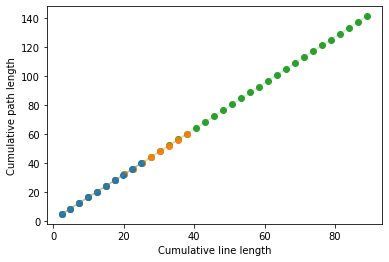

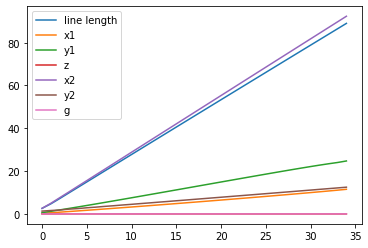

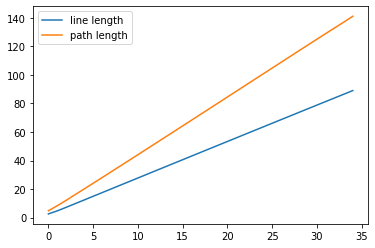

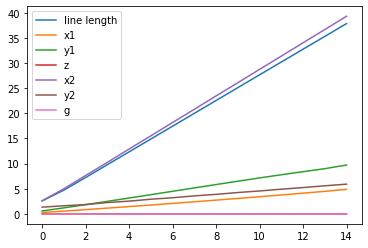

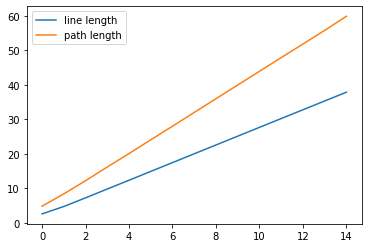

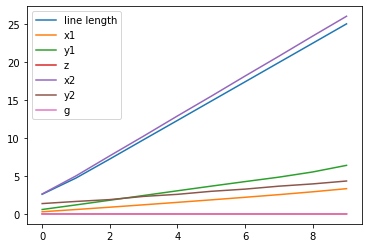

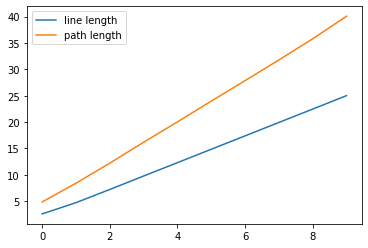

In [26]:
fig, ax = plt.subplots()
ts = -llq[:, :, 0] + llq[:, :, 3]
for ix0, x0 in enumerate(lx0[::-1]):
    ix0 = 2-ix0 # to reverse the order of plotting

    t_stim_onsets = []
    for i_stim in range(n_stim):
        tc = (t_start + i_stim*I_duration + i_stim*I_inter)*upsamp
        if tc<lte[ix0]-1000:
            t_stim_onsets.append(tc)

    dif = []
    for istim in range(len(t_stim_onsets)):
        # dif.append(np.sum(np.abs(np.diff(ts[in_stim, int(t_stim_onsets[istim]+0*upsamp):int(t_stim_onsets[istim]+5*upsamp)]))))
        dif.append(np.sum(np.abs(np.diff(ts[ix0, int(t_stim_onsets[istim]+0.*upsamp):int(t_stim_onsets[istim]+3*upsamp)]))))

    dif_6d = []
    for istim in range(len(t_stim_onsets)):
        for idim in range(6):
            qc = llq[ix0, int(t_stim_onsets[istim]):int(t_stim_onsets[istim]+3*upsamp), idim]
            dif_6d.append(np.sum(np.abs(np.diff(qc))))

    dif_6dr = np.reshape(dif_6d, (len(t_stim_onsets), 6))

    plt.figure()
    plt.plot(np.cumsum(dif), label='line length')
    plt.plot(np.cumsum(dif_6dr, 0), label=['x1', 'y1', 'z', 'x2', 'y2', 'g'])
    plt.legend()
    # plt.xticks(range(len(dif)), np.round(lx0, 2))
    plt.savefig('figures/train_line_length_path_length_all_ts_diff_exc.svg')

    plt.figure()
    plt.plot(np.cumsum(dif), label='line length')
    plt.plot(np.cumsum(np.sum(dif_6dr, 1)), label='path length')
    plt.legend()
    # plt.xticks(range(len(dif)), np.round(lx0, 2))
    plt.savefig('figures/train_line_length_path_length_sum6d_ts_diff_exc.svg')


    ax.scatter(np.cumsum(dif), np.cumsum(np.sum(dif_6dr, 1)), color=cm[ix0])
    ax.plot(np.cumsum(dif), np.cumsum(np.sum(dif_6dr, 1)), color=cm[ix0], alpha=.2)
    ax.set_xlabel('Cumulative line length')
    ax.set_ylabel('Cumulative path length')
    plt.savefig('figures/cum_line_length_cum_path_length_scatter_diff_exc.svg')

### Phase space for population 1

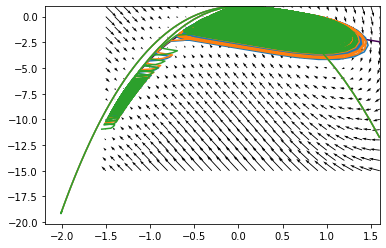

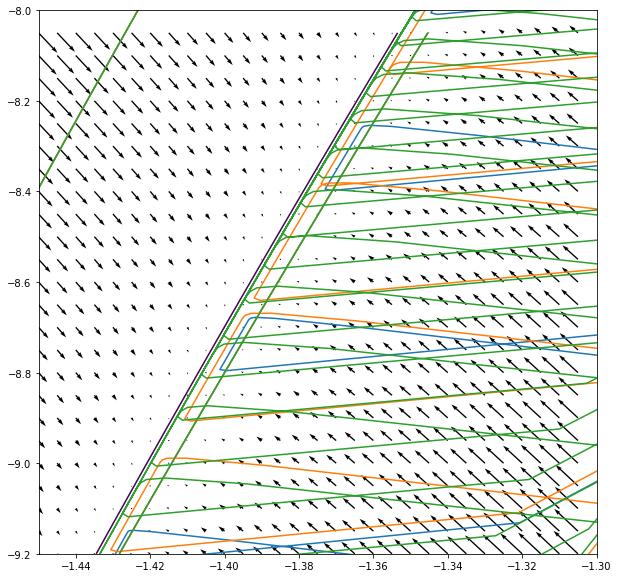

In [114]:
def pop1(x1, y1, z, x2, parameters):

    a1, b1, c1, d1, tau, a2, c2, m, x0, r, s, Irest1, Irest2, Is1, Is2 =\
    parameters['a1'], parameters['b1'], parameters['c1'], parameters['d1'], parameters['tau'], \
    parameters['a2'], parameters['c2'], parameters['m'], parameters['x0'], parameters['r'], \
    parameters['s'], parameters['Irest1'], parameters['Irest2'], parameters['Is1'], parameters['Is2']

    # q0 = [x1, y1,  2.92, -0.71,  0., -0.14]
    # q = fsolve(epileptor, q0, args=parameters)
    # z = q[2] 

    dx1 = np.where(x1<0, y1  - a1 * (x1)**3  + b1 * (x1)**2 - z + Irest1 + Is1 + .1*(x2 + .7), 
                   y1 + (m -x2 + 0.6 * (z-4)**2)*x1- z + Irest1 + Is1)
    dy1 = c1 - d1 * (x1)**2 - y1
    return (dx1, dy1)


parameters = {'a1':1, 'b1':3, 'c1':1, 'd1':5,
              'tau':10, 'a2':6, 'c2':0.3, 'm':0,
              'x0':-2.11, 'r':0.00035, 's':4,
              'Irest1':3.1, 'Irest2':0.45, 'Is1':0, 'Is2':0}


x1r = np.arange(-1.5, 1.7, 0.1)
y1r = np.arange(-15, 2., 1.)
x1, y1 = np.meshgrid(x1r, y1r)
q0 = [-1.37, -8.39,  2.92, -0.71,  0.  , -0.14]
q = fsolve(epileptor, q0, args=parameters)
z = q[2]
x2 = q[3]
(x1d, y1d) = pop1(x1, y1, z, x2, parameters)

plt.figure()
plt.quiver(x1, y1, x1d, y1d)
plt.contour(x1, y1, x1d, [0])
# tend = 220000
for ix0, x0 in enumerate(lx0):
    parameters['x0'] = x0
    q0 = [-1.37, -8.39,  2.92, -0.71,  0.  , -0.14]
    q = fsolve(epileptor, q0, args=parameters)
    z = q[2]
    x2 = q[3]
    (x1d, y1d) = pop1(x1, y1, z, x2, parameters)
    plt.contour(x1, y1, y1d, [0], colors=cm[ix0])
    tend = int(1.1*lte[ix0]/dt)
    plt.plot(llq[ix0, :tend, 0], llq[ix0, :tend, 1], color=cm[ix0], label=str(np.round(x0, 2)))
plt.savefig('figures/phase_space_diff_exc_pop1.svg')

x1r = np.arange(-1.45, -1.3, .005)
y1r = np.arange(-9.2, -8., .05)
x1, y1 = np.meshgrid(x1r, y1r)
q0 = [-1.37, -8.39,  2.92, -0.71,  0.  , -0.14]
q = fsolve(epileptor, q0, args=parameters)
z = q[2]
x2 = q[3]
(x1d, y1d) = pop1(x1, y1, z, x2, parameters)

plt.figure(figsize=(10, 10))
plt.quiver(x1, y1, x1d, y1d)
plt.contour(x1, y1, x1d, [0])
for ix0, x0 in enumerate(lx0):
    parameters['x0'] = x0
    q0 = [-1.37, -8.39,  2.92, -0.71,  0.  , -0.14]
    q = fsolve(epileptor, q0, args=parameters)
    z = q[2]
    x2 = q[3]
    (x1d, y1d) = pop1(x1, y1, z, x2, parameters)
    plt.contour(x1, y1, y1d, [0], colors=cm[ix0])
    plt.plot(llq[ix0, :tend, 0], llq[ix0, :tend, 1], color=cm[ix0], label=str(np.round(x0, 2)))
plt.xlim([-1.45, -1.3])
plt.ylim([-9.2, -8])
# plt.xlim([-1.4, -1.2])
# plt.ylim([-9, -7])
plt.savefig('figures/phase_space_diff_exc_pop1_zoomed.svg')